In [ ]:
import torch
from torch.cuda.amp import autocast

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import KDTree

In [ ]:
size = 1_000_000
ptc_points = np.random.random(size=(size, 3))
ptc_feats = np.random.random(size=(size, 384))
ptc_feats[:500000] = np.zeros((500000, 384))

missing_idx = np.random.randint(0, size, size=100_000)

tree = KDTree(ptc_points, leaf_size=10)

In [ ]:
# make batches
batch_size = 100
batches = np.array_split(missing_idx, len(missing_idx) // batch_size)

In [ ]:
test = np.array([[], [], []])
out = test.mean()

In [ ]:
np.isnan(out)

In [ ]:
for batch in batches:
    # find nearest neighbors
    dist, idx = tree.query(ptc_points[batch], k=10)
    # replace missing values with mean over nearest neighbors, but filter out zero values in 
    neighbors = ptc_feats[idx]
    # filter out neighbord features that are np.zero(3)
    mask = ~np.all(neighbors == 0, axis=2)
    # extend mask
    mask = np.repeat(mask[:, :, np.newaxis], 384, axis=2)
    neighbors_mean = neighbors.mean(axis=1, where=mask)
    ptc_feats[batch] = neighbors_mean
    print(np.isnan(neighbors_mean))

In [ ]:
neighbors_mean.shape

In [ ]:
ptc_points.shape

In [ ]:
ptc_points[idx].mean(axis=1)

In [ ]:

for idx in tqdm(missing_idx, total=len(missing_idx), desc="KNN interpolation"):
    dist, ind = tree.query([ptc_points[idx]], k=20)
    neighbors = ptc_points[ind[0]]
    neighbors = neighbors[neighbors[:, 0] != 0]
    ptc_points[idx] = np.mean(neighbors, axis=0)

# DINOV2

## Patch Features

In [ ]:


import os
import sys

os.environ["XFORMERS_DISABLED"] = "1" 

In [ ]:


import urllib

import io
import numpy as np
from PIL import Image


def load_array_from_url(url: str) -> np.ndarray:
    with urllib.request.urlopen(url) as f:
        array_data = f.read()
        g = io.BytesIO(array_data)
        return np.load(g)


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


# Precomputed foreground / background projection
STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"
standard_array = load_array_from_url(STANDARD_ARRAY_URL)

EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
example_image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(example_image)



In [ ]:
example_image.size

In [ ]:
640 // 14

In [ ]:
import torch
import torchvision.transforms as transforms
from typing import Tuple
from torch import Tensor
from einops import rearrange


def load_dino(cfg):
    model = torch.hub.load("facebookresearch/dinov2", cfg.model_name).cuda()
    model.eval()
    return model

def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BILINEAR

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])

def prepare_image(image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))

    image_tensor = transform(image)
    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w
    return image_tensor, grid_size

def get_dino_features(model, image, patch_size=14):
    C, H, W = image.shape
    interpolation = transforms.Resize(size=(H, W), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True)
    
    smaller_edge_size = min(H, W)
    image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

    with torch.inference_mode():
        image_batch = image_tensor.cuda().unsqueeze(0)
        t = model.get_intermediate_layers(image_batch)[0].squeeze().cpu()
    
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)
    
    features = normalized_t.reshape(*grid_size, -1)
    features = rearrange(features, "h w c -> 1 c h w")
    features = interpolation(features)
    return features

In [ ]:
from omegaconf import OmegaConf, DictConfig

cfg = {"model_name": "dinov2_vits14"}
cfg = DictConfig(cfg)


model = load_dino(cfg)

In [ ]:
image = torch.tensor(np.array(example_image) / 255.0).permute(2, 0, 1).float()

In [ ]:
feats = get_dino_features(model, image)

In [ ]:
feats.shape

In [ ]:
from typing import Tuple

import numpy as np
from PIL import Image
from PIL.Image import Resampling
from sklearn.decomposition import PCA
from scipy.ndimage import binary_closing, binary_opening
import torch
import torchvision.transforms as transforms


REPO_NAME = 
MODEL_NAME = "dinov2_vits14"


DEFAULT_SMALLER_EDGE_SIZE = 448
DEFAULT_BACKGROUND_THRESHOLD = -100
DEFAULT_APPLY_OPENING = False
DEFAULT_APPLY_CLOSING = False


def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])


def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size


def make_foreground_mask(tokens,
                         grid_size: Tuple[int, int],
                         background_threshold: float = 0.0,
                         apply_opening: bool = True,
                         apply_closing: bool = True):
    projection = tokens @ standard_array
    mask = projection > background_threshold
    mask = mask.reshape(*grid_size)
    if apply_opening:
        mask = binary_opening(mask)
    if apply_closing:
        mask = binary_closing(mask)
    return mask.flatten()


def render_patch_pca(image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 14,
                     background_threshold: float = 0.05,
                     apply_opening: bool = False,
                     apply_closing: bool = False) -> Image:
    image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0).cuda()
        tokens = model.get_intermediate_layers(image_batch)[0].squeeze().cpu()
        print(tokens.shape)

    if False:
        mask = make_foreground_mask(tokens,
                                    grid_size,
                                    background_threshold,
                                    apply_opening,
                                    apply_closing)

    pca = PCA(n_components=10)
    #pca.fit(tokens[mask])
    pca.fit(tokens)
    projected_tokens = pca.transform(tokens)

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    #array[~mask] = 0
    print(array.shape, grid_size)
    array = array[..., :3]
    array = array.reshape(*grid_size, 3)

    return Image.fromarray(array).resize((image.width, image.height), resample=Resampling.BICUBIC)



print(f"using {MODEL_NAME} model")
model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAME).cuda()
model.eval()
print(f"patch size: {model.patch_size}")

render_patch_pca(image=example_image,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=DEFAULT_BACKGROUND_THRESHOLD,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)


In [ ]:
32*42

## General

In [ ]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').cuda().eval()

In [ ]:
test_img = torch.randn(1, 3, 1400, 1400).cuda()
with torch.inference_mode():
    out = dinov2_vits14.get_intermediate_layers(test_img)

print(out[0].shape)

In [ ]:
384**0.5

In [ ]:
torch.nn.int()

In [ ]:
import torch

In [ ]:
with torch.no_grad():
    out = model(test_img, return_patches=True)[0]

In [ ]:
out.shape

In [ ]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from third_party.dinov2.dinov2.eval.depth.models import build_depther

class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

In [ ]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

In [ ]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_DATASET = "nyu" # in ("nyu", "kitti")
HEAD_TYPE = "dpt" # in ("linear", "linear4", "dpt")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.utils.Config.fromstring(cfg_str, file_format=".py")

model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=HEAD_TYPE,
)

load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.eval()
model.cuda()

In [ ]:
model.decode_head.fusion_blocks = torch.nn.Sequential(torch.nn.Identity())
model.decode_head.project = torch.nn.Identity()

In [ ]:
test_img = torch.randn(1, 3, 224, 224).cuda()
with torch.no_grad():
    out = model.whole_inference(test_img, img_meta=None, rescale=True)
out.shape

In [ ]:
out

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(out[0].cpu().squeeze().numpy())

In [ ]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"


image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

In [ ]:


import matplotlib
from torchvision import transforms


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = image.resize((scale_factor * image.width, scale_factor * image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
display(depth_image)

In [ ]:
result

# DINO V1

In [ ]:
import argparse
import torch
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image


class ViTExtractor:
    """ This class facilitates extraction of features, descriptors, and saliency maps from a ViT.

    We use the following notation in the documentation of the module's methods:
    B - batch size
    h - number of heads. usually takes place of the channel dimension in pytorch's convention BxCxHxW
    p - patch size of the ViT. either 8 or 16.
    t - number of tokens. equals the number of patches + 1, e.g. HW / p**2 + 1. Where H and W are the height and width
    of the input image.
    d - the embedding dimension in the ViT.
    """

    def __init__(self, model_type: str = 'dino_vits8', stride: int = 4, model: nn.Module = None, device: str = 'cuda'):
        """
        :param model_type: A string specifying the type of model to extract from.
                          [dino_vits8 | dino_vits16 | dino_vitb8 | dino_vitb16 | vit_small_patch8_224 |
                          vit_small_patch16_224 | vit_base_patch8_224 | vit_base_patch16_224]
        :param stride: stride of first convolution layer. small stride -> higher resolution.
        :param model: Optional parameter. The nn.Module to extract from instead of creating a new one in ViTExtractor.
                      should be compatible with model_type.
        """
        self.model_type = model_type
        self.device = device
        if model is not None:
            self.model = model
        else:
            self.model = ViTExtractor.create_model(model_type)

        self.model = ViTExtractor.patch_vit_resolution(self.model, stride=stride)
        self.model.eval()
        self.model.to(self.device)
        self.p = self.model.patch_embed.patch_size
        self.stride = self.model.patch_embed.proj.stride

        self.mean = (0.485, 0.456, 0.406) if "dino" in self.model_type else (0.5, 0.5, 0.5)
        self.std = (0.229, 0.224, 0.225) if "dino" in self.model_type else (0.5, 0.5, 0.5)

        self._feats = []
        self.hook_handlers = []
        self.load_size = None
        self.num_patches = None

    @staticmethod
    def create_model(model_type: str) -> nn.Module:
        """
        :param model_type: a string specifying which model to load. [dino_vits8 | dino_vits16 | dino_vitb8 |
                           dino_vitb16 | vit_small_patch8_224 | vit_small_patch16_224 | vit_base_patch8_224 |
                           vit_base_patch16_224]
        :return: the model
        """
        if 'dino' in model_type:
            model = torch.hub.load('facebookresearch/dino:main', model_type)
        else:  # model from timm -- load weights from timm to dino model (enables working on arbitrary size images).
            temp_model = timm.create_model(model_type, pretrained=True)
            model_type_dict = {
                'vit_small_patch16_224': 'dino_vits16',
                'vit_small_patch8_224': 'dino_vits8',
                'vit_base_patch16_224': 'dino_vitb16',
                'vit_base_patch8_224': 'dino_vitb8'
            }
            model = torch.hub.load('facebookresearch/dino:main', model_type_dict[model_type])
            temp_state_dict = temp_model.state_dict()
            del temp_state_dict['head.weight']
            del temp_state_dict['head.bias']
            model.load_state_dict(temp_state_dict)
        return model

    @staticmethod
    def _fix_pos_enc(patch_size: int, stride_hw: Tuple[int, int]):
        """
        Creates a method for position encoding interpolation.
        :param patch_size: patch size of the model.
        :param stride_hw: A tuple containing the new height and width stride respectively.
        :return: the interpolation method
        """
        def interpolate_pos_encoding(self, x: torch.Tensor, w: int, h: int) -> torch.Tensor:
            npatch = x.shape[1] - 1
            N = self.pos_embed.shape[1] - 1
            if npatch == N and w == h:
                return self.pos_embed
            class_pos_embed = self.pos_embed[:, 0]
            patch_pos_embed = self.pos_embed[:, 1:]
            dim = x.shape[-1]
            # compute number of tokens taking stride into account
            w0 = 1 + (w - patch_size) // stride_hw[1]
            h0 = 1 + (h - patch_size) // stride_hw[0]
            assert (w0 * h0 == npatch), f"""got wrong grid size for {h}x{w} with patch_size {patch_size} and 
                                            stride {stride_hw} got {h0}x{w0}={h0 * w0} expecting {npatch}"""
            # we add a small number to avoid floating point error in the interpolation
            # see discussion at https://github.com/facebookresearch/dino/issues/8
            w0, h0 = w0 + 0.1, h0 + 0.1
            patch_pos_embed = nn.functional.interpolate(
                patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
                scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
                mode='bicubic',
                align_corners=False, recompute_scale_factor=False
            )
            assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
            patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
            return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

        return interpolate_pos_encoding

    @staticmethod
    def patch_vit_resolution(model: nn.Module, stride: int) -> nn.Module:
        """
        change resolution of model output by changing the stride of the patch extraction.
        :param model: the model to change resolution for.
        :param stride: the new stride parameter.
        :return: the adjusted model
        """
        patch_size = model.patch_embed.patch_size
        if stride == patch_size:  # nothing to do
            return model

        stride = nn_utils._pair(stride)
        assert all([(patch_size // s_) * s_ == patch_size for s_ in
                    stride]), f'stride {stride} should divide patch_size {patch_size}'

        # fix the stride
        model.patch_embed.proj.stride = stride
        # fix the positional encoding code
        model.interpolate_pos_encoding = types.MethodType(ViTExtractor._fix_pos_enc(patch_size, stride), model)
        return model

    def preprocess(self, image: torch.Tensor,
                   load_size: Union[int, Tuple[int, int]] = None) -> Tuple[torch.Tensor, Image.Image]:
        """
        Preprocesses an image before extraction.
        :param image_path: path to image to be extracted.
        :param load_size: optional. Size to resize image before the rest of preprocessing.
        :return: a tuple containing:
                    (1) the preprocessed image as a tensor to insert the model of shape BxCxHxW.
                    (2) the pil image in relevant dimensions
        """
        # pil_image = image.convert('RGB')
        # if load_size is not None:
        #     pil_image = transforms.Resize(load_size, interpolation=transforms.InterpolationMode.LANCZOS)(pil_image)
        prep = transforms.Compose([
            # transforms.ToTensor(),
            transforms.Resize(load_size, antialias=None),
            transforms.Normalize(mean=self.mean, std=self.std)
        ])
        prep_img = prep(image)[None, ...]
        return prep_img

    def _get_hook(self, facet: str):
        """
        generate a hook method for a specific block and facet.
        """
        if facet in ['attn', 'token']:
            def _hook(model, input, output):
                self._feats.append(output)
            return _hook

        if facet == 'query':
            facet_idx = 0
        elif facet == 'key':
            facet_idx = 1
        elif facet == 'value':
            facet_idx = 2
        else:
            raise TypeError(f"{facet} is not a supported facet.")

        def _inner_hook(module, input, output):
            input = input[0]
            B, N, C = input.shape
            qkv = module.qkv(input).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
            self._feats.append(qkv[facet_idx]) #Bxhxtxd
        return _inner_hook

    def _register_hooks(self, layers: List[int], facet: str) -> None:
        """
        register hook to extract features.
        :param layers: layers from which to extract features.
        :param facet: facet to extract. One of the following options: ['key' | 'query' | 'value' | 'token' | 'attn']
        """
        for block_idx, block in enumerate(self.model.blocks):
            if block_idx in layers:
                if facet == 'token':
                    self.hook_handlers.append(block.register_forward_hook(self._get_hook(facet)))
                elif facet == 'attn':
                    self.hook_handlers.append(block.attn.attn_drop.register_forward_hook(self._get_hook(facet)))
                elif facet in ['key', 'query', 'value']:
                    self.hook_handlers.append(block.attn.register_forward_hook(self._get_hook(facet)))
                else:
                    raise TypeError(f"{facet} is not a supported facet.")

    def _unregister_hooks(self) -> None:
        """
        unregisters the hooks. should be called after feature extraction.
        """
        for handle in self.hook_handlers:
            handle.remove()
        self.hook_handlers = []

    def _extract_features(self, batch: torch.Tensor, layers: List[int] = 11, facet: str = 'key') -> List[torch.Tensor]:
        """
        extract features from the model
        :param batch: batch to extract features for. Has shape BxCxHxW.
        :param layers: layer to extract. A number between 0 to 11.
        :param facet: facet to extract. One of the following options: ['key' | 'query' | 'value' | 'token' | 'attn']
        :return : tensor of features.
                  if facet is 'key' | 'query' | 'value' has shape Bxhxtxd
                  if facet is 'attn' has shape Bxhxtxt
                  if facet is 'token' has shape Bxtxd
        """
        B, C, H, W = batch.shape
        self._feats = []
        self._register_hooks(layers, facet)
        _ = self.model(batch)
        self._unregister_hooks()
        self.load_size = (H, W)
        self.num_patches = (1 + (H - self.p) // self.stride[0], 1 + (W - self.p) // self.stride[1])
        return self._feats

    def _log_bin(self, x: torch.Tensor, hierarchy: int = 2) -> torch.Tensor:
        """
        create a log-binned descriptor.
        :param x: tensor of features. Has shape Bxhxtxd.
        :param hierarchy: how many bin hierarchies to use.
        """
        B = x.shape[0]
        num_bins = 1 + 8 * hierarchy

        bin_x = x.permute(0, 2, 3, 1).flatten(start_dim=-2, end_dim=-1)  # Bx(t-1)x(dxh)
        bin_x = bin_x.permute(0, 2, 1)
        bin_x = bin_x.reshape(B, bin_x.shape[1], self.num_patches[0], self.num_patches[1])
        # Bx(dxh)xnum_patches[0]xnum_patches[1]
        sub_desc_dim = bin_x.shape[1]

        avg_pools = []
        # compute bins of all sizes for all spatial locations.
        for k in range(0, hierarchy):
            # avg pooling with kernel 3**kx3**k
            win_size = 3 ** k
            avg_pool = torch.nn.AvgPool2d(win_size, stride=1, padding=win_size // 2, count_include_pad=False)
            avg_pools.append(avg_pool(bin_x))

        bin_x = torch.zeros((B, sub_desc_dim * num_bins, self.num_patches[0], self.num_patches[1])).to(self.device)
        for y in range(self.num_patches[0]):
            for x in range(self.num_patches[1]):
                part_idx = 0
                # fill all bins for a spatial location (y, x)
                for k in range(0, hierarchy):
                    kernel_size = 3 ** k
                    for i in range(y - kernel_size, y + kernel_size + 1, kernel_size):
                        for j in range(x - kernel_size, x + kernel_size + 1, kernel_size):
                            if i == y and j == x and k != 0:
                                continue
                            if 0 <= i < self.num_patches[0] and 0 <= j < self.num_patches[1]:
                                bin_x[:, part_idx * sub_desc_dim: (part_idx + 1) * sub_desc_dim, y, x] = avg_pools[k][
                                                                                                           :, :, i, j]
                            else:  # handle padding in a more delicate way than zero padding
                                temp_i = max(0, min(i, self.num_patches[0] - 1))
                                temp_j = max(0, min(j, self.num_patches[1] - 1))
                                bin_x[:, part_idx * sub_desc_dim: (part_idx + 1) * sub_desc_dim, y, x] = avg_pools[k][
                                                                                                           :, :, temp_i,
                                                                                                           temp_j]
                            part_idx += 1
        bin_x = bin_x.flatten(start_dim=-2, end_dim=-1).permute(0, 2, 1).unsqueeze(dim=1)
        # Bx1x(t-1)x(dxh)
        return bin_x

    def extract_descriptors(self, batch: torch.Tensor, layer: List[int], facet: str = 'key',
                            bin: bool = False, include_cls: bool = False) -> torch.Tensor:
        """
        extract descriptors from the model
        :param batch: batch to extract descriptors for. Has shape BxCxHxW.
        :param layers: layer to extract. A number between 0 to 11.
        :param facet: facet to extract. One of the following options: ['key' | 'query' | 'value' | 'token']
        :param bin: apply log binning to the descriptor. default is False.
        :return: tensor of descriptors. Bx1xtxd' where d' is the dimension of the descriptors.
        """
        assert facet in ['key', 'query', 'value', 'token'], f"""{facet} is not a supported facet for descriptors. 
                                                             choose from ['key' | 'query' | 'value' | 'token'] """
        self._extract_features(batch, layer, facet)
        x = torch.concat(self._feats)
        # if facet == 'token':
        #     x.unsqueeze_(dim=1) #Bx1xtxd
        if not include_cls:
            x = x[:, :, 1:, :]  # remove cls token
        else:
            assert not bin, "bin = True and include_cls = True are not supported together, set one of them False."
        if not bin:
            desc = x.permute(0, 2, 3, 1).flatten(start_dim=-2, end_dim=-1).unsqueeze(dim=1)  # Bx1xtx(dxh)
        else:
            desc = self._log_bin(x)
        return desc

    def extract_saliency_maps(self, batch: torch.Tensor) -> torch.Tensor:
        """
        extract saliency maps. The saliency maps are extracted by averaging several attention heads from the last layer
        in of the CLS token. All values are then normalized to range between 0 and 1.
        :param batch: batch to extract saliency maps for. Has shape BxCxHxW.
        :return: a tensor of saliency maps. has shape Bxt-1
        """
        assert self.model_type == "dino_vits8", f"saliency maps are supported only for dino_vits model_type."
        self._extract_features(batch, [11], 'attn')
        head_idxs = [0, 2, 4, 5]
        curr_feats = self._feats[0] #Bxhxtxt
        cls_attn_map = curr_feats[:, head_idxs, 0, 1:].mean(dim=1) #Bx(t-1)
        temp_mins, temp_maxs = cls_attn_map.min(dim=1)[0], cls_attn_map.max(dim=1)[0]
        cls_attn_maps = (cls_attn_map - temp_mins) / (temp_maxs - temp_mins)  # normalize to range [0,1]
        return cls_attn_maps

""" taken from https://stackoverflow.com/questions/15008758/parsing-boolean-values-with-argparse"""
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Facilitate ViT Descriptor extraction.')
    parser.add_argument('--image_path', type=str, required=True, help='path of the extracted image.')
    parser.add_argument('--output_path', type=str, required=True, help='path to file containing extracted descriptors.')
    parser.add_argument('--load_size', default=224, type=int, help='load size of the input image.')
    parser.add_argument('--stride', default=4, type=int, help="""stride of first convolution layer. 
                                                              small stride -> higher resolution.""")
    parser.add_argument('--model_type', default='dino_vits8', type=str,
                        help="""type of model to extract. 
                        Choose from [dino_vits8 | dino_vits16 | dino_vitb8 | dino_vitb16 | vit_small_patch8_224 | 
                        vit_small_patch16_224 | vit_base_patch8_224 | vit_base_patch16_224]""")
    parser.add_argument('--facet', default='key', type=str, help="""facet to create descriptors from. 
                                                                    options: ['key' | 'query' | 'value' | 'token']""")
    parser.add_argument('--layer', default=11, type=int, help="layer to create descriptors from.")
    parser.add_argument('--bin', default='False', type=str2bool, help="create a binned descriptor if True.")

    args = parser.parse_args()

    with torch.no_grad():
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        extractor = ViTExtractor(args.model_type, args.stride, device=device)
        image_batch, image_pil = extractor.preprocess(args.image_path, args.load_size)
        print(f"Image {args.image_path} is preprocessed to tensor of size {image_batch.shape}.")
        descriptors = extractor.extract_descriptors(image_batch.to(device), args.layer, args.facet, args.bin)
        print(f"Descriptors are of size: {descriptors.shape}")
        torch.save(descriptors, args.output_path)
        print(f"Descriptors saved to: {args.output_path}")

    import pdb; pdb.set_trace()
    print()
'''

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_type = 'dino_vitb8'
stride = 4
load_size = 224
test_image = torch.randn(3, 224, 224).cuda()
layer = [11]
facet = 'key'
bin = False

extractor = ViTExtractor(model_type, stride, device=device)
image_batch = extractor.preprocess(test_image, load_size)
print(f"Image is preprocessed to tensor of size {image_batch.shape}.")
descriptors = extractor.extract_descriptors(image_batch.to(device), layer, facet, bin)
descriptors.shape

In [ ]:
2809*384

In [ ]:
import torch

def extract_feature(model, frame, return_h_w=False):
    """Extract one frame feature everytime."""
    out = model.get_intermediate_layers(frame.unsqueeze(0).cuda(), n=1)[0]
    out = out[:, 1:, :]  # we discard the [CLS] token
    h, w = int(frame.shape[1] / model.patch_embed.patch_size), int(frame.shape[2] / model.patch_embed.patch_size)
    dim = out.shape[-1]
    out = out[0].reshape(h, w, dim)
    #out = out.reshape(-1, dim)
    #if return_h_w:
    #    return out, h, w
    return out

In [ ]:
vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16').cuda()

# OPENCLIP

In [ ]:
import open_clip
import torch
from PIL import Image

In [ ]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

In [ ]:
model.token_embedding = torch.nn.Identity()
model.ln_final = torch.nn.Identity()

In [ ]:
model(torch.randn(1, 3, 224, 224))[0].shape

In [ ]:
image = preprocess(Image.open("../room.jpeg")).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    #image_features /= image_features.norm(dim=-1, keepdim=True)

In [ ]:
image_features.shape

# Image Feature Lookup

In [ ]:
from third_party.scannetpp.common.utils.colmap import read_model
from third_party.scannetpp.common.scene_release import ScannetppScene_Release
import open3d as o3d
import numpy as np
import json
from tqdm import tqdm

In [ ]:
scene_id = "036bce3393"
data_root = "../datasets/scannetpp/"
movie_path = "../datasets/scannetpp/036bce3393/iphone/rgb.mp4"

In [ ]:
scene = ScannetppScene_Release(scene_id, data_root=data_root)
mesh_path = scene.scan_mesh_path

colmap_dir = scene.iphone_colmap_dir
cameras, images, points3D = read_model(colmap_dir, ".txt")

In [ ]:
mesh = o3d.io.read_triangle_mesh(str(mesh_path))
pointcloud = o3d.geometry.PointCloud(mesh.vertices)

In [ ]:
# add black color to pointcloud
pointcloud.colors = o3d.utility.Vector3dVector(np.zeros_like(mesh.vertices))

In [ ]:
from decord import VideoReader
from decord import cpu

In [ ]:
# read the mp4
import cv2

vr = VideoReader(movie_path, ctx=cpu(0))

In [ ]:
skip_frames = 10
frame_idxs = np.linspace(0, vr._num_frame//skip_frames * skip_frames ,round(vr._num_frame//skip_frames+1), dtype=np.int32)
videoframes = vr.get_batch(frame_idxs).asnumpy()

In [ ]:
def project_point_cloud(points, translation, rotation, camera_matrix):
    # Assuming points is already a NumPy array
    points_transformed = np.dot(rotation, points.T) + translation
    points_projected = np.dot(camera_matrix, points_transformed)
    points_projected[:2, :] /= points_projected[2, :]
    return points_projected.T

def filter_points(points_projected, image_width, image_height, min_depth=0.1, max_depth=1000):
    # Check within image bounds and positive depth
    in_image_bounds = (points_projected[:, 0] >= 0) & (points_projected[:, 0] < image_width) & \
                      (points_projected[:, 1] >= 0) & (points_projected[:, 1] < image_height)
    valid_depth = (points_projected[:, 2] > min_depth) & (points_projected[:, 2] < max_depth)
    valid_indices = in_image_bounds & valid_depth
    return valid_indices

def map_image_features_to_ptc(image, valid_points_2d, valid_indices):
    # Assuming valid_points_2d is a NumPy array
    x, y = valid_points_2d[:, 0].astype(int), valid_points_2d[:, 1].astype(int)
    rgb_values = image[y, x]  # Efficient bulk operation
    return rgb_values, valid_indices

def update_features(feature_list, feature_values, valid_indices):
    # convert valid_indices to indexes
    valid_indices = np.where(valid_indices)[0]
    for feature, valid_index in zip(feature_values, valid_indices):
        feature_list[valid_index].append(feature)
    return feature_list

In [ ]:
iphone_intrinsics_path = scene.iphone_pose_intrinsic_imu_path
iphone_intrinsics = json.load(open(iphone_intrinsics_path))

In [ ]:
image_width = 1920
image_height = 1440

In [ ]:
points = np.array(pointcloud.points)

In [ ]:
ptc_points = [[] for _ in range(len(points))]

In [ ]:
for image_idx, image in tqdm(images.items()):
        if image_idx % 5 != 0:
            continue
        world_to_camera = image.world_to_camera
        camera_to_world = np.linalg.inv(world_to_camera)
        
        # plot axis
        axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
        axis.transform(camera_to_world)
        #vis.add_geometry(axis)
        
        # extract video frame
        frame_name = image.name
        frame = int(frame_name.split('_')[-1].split('.')[0]) // 10
        videoframe = videoframes[frame] / 255.0
        
        # project the mesh on the camera and extract the rgb values from the videoframe
        iphone_data = iphone_intrinsics[frame_name.split('.')[0]]
        intrinsic_matrix = iphone_data['intrinsic']
        
        R = world_to_camera[:3, :3]
        t = world_to_camera[:-1, -1:]
        
        # project points
        points_projected = project_point_cloud(points, t, R, intrinsic_matrix)
        valid_indices = filter_points(points_projected, image_width, image_height)
        rgb_feats, valid_indices = map_image_features_to_ptc(videoframe, points_projected[valid_indices], valid_indices)
        update_features(ptc_points, rgb_feats, valid_indices)

In [ ]:
missing_idx = []

for idx, f in tqdm(enumerate(ptc_points)):
    if len(f) > 0:
        f = np.array(f)
        ptc_points[idx] = np.median(f, axis=0)
    else:
        ptc_points[idx] = np.zeros(3)
        missing_idx.append(idx)

In [ ]:
ptcf = np.array(ptc_points)

In [ ]:
ptcf_copy = ptcf.copy()

In [ ]:
# for every missing idx do a knn search and replace the value
from scipy.spatial import KDTree

tree = KDTree(ptcf)
for idx in tqdm(missing_idx):
    dist, ind = tree.query([ptcf[idx]], k=20)
    neighbors = ptcf[ind[0]]
    neighbors = neighbors[neighbors[:, 0] != 0]
    ptcf[idx] = np.mean(neighbors, axis=0)

In [ ]:
np.asarray(pointcloud.colors)[:,:] = ptcf_copy

In [ ]:
vis = o3d.visualization.Visualizer()
vis.create_window()

In [ ]:
vis.add_geometry(pointcloud)

In [ ]:
vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

In [ ]:
print(filtered.astype(np.int32))

# Visualization

In [ ]:
%load_ext autoreload
%autoreload 2

import open3d as o3d
import torch
import numpy as np
import os
import glob

In [ ]:
models = {
    "scannet_cut_small_st": "ST",
    "scannet_cut_small_pvd_st": "PVD + ST",
    "scannet_cut_small_pvd_large_mse": "PVD",
    "scannet_cut_small_mink": "Mink"
}

ckpt = "99999"
config = "DDPM(T=200)_clip"
idx = "000"

data = {}

for model in models:
    path = os.path.join("checkpoints", model, "sampling", ckpt, config)
    gt_path = os.path.join(path, idx+"_gt_highres.npy")
    hints_path = os.path.join(path, idx+"_hints.npy")
    pred_path = os.path.join(path, idx+"_pred.npy")

    gt = np.load(gt_path)
    hints = np.load(hints_path)
    pred = np.load(pred_path)
    new_data = {
        "gt": gt,
        "hints": hints,
        "pred": pred
    }
    data[models[model]] = new_data

In [ ]:
green = np.array([0, 255, 0])
red = np.array([255, 0, 0])
black = np.array([0, 0, 0])
blue = np.array([0, 0, 255])
orange = np.array([255, 165, 0])
colors = [red, black, blue, orange]

In [ ]:
from einops import rearrange, repeat
import pyviz3d.visualizer as viz

v = viz.Visualizer()

pointsize = 3
for idx, model in enumerate(data):
    pred = data[model]["pred"].swapaxes(1, 2)
    hints = data[model]["hints"].swapaxes(1, 2)
    gt = data[model]["gt"].swapaxes(1, 2)
    B, N, C = pred.shape

    col = colors[idx]
    for batch_idx in range(pred.shape[0]):
        v.add_points(point_size=pointsize, positions=pred[batch_idx], colors=repeat(col, 'C -> N C', C=C, N=N), name=model+"_pred_"+str(batch_idx), visible=False)
        v.add_points(point_size=pointsize, positions=hints[batch_idx], colors=repeat(col, 'C -> N C', C=C, N=N), name=model+"_hints_"+str(batch_idx), visible=False)
        v.add_points(point_size=pointsize, positions=gt[batch_idx], colors=repeat(col, 'C -> N C', C=C, N=N), name=model+"_gt_"+str(batch_idx), visible=False)

v.save("plot_superviz")

# Simple Stuff

In [ ]:
import torch
from omegaconf import OmegaConf

from model.unet_mink import MinkUnet
from model.unet_pointvoxel import PVCLionSmall

pvd_model = "checkpoints/scannet_cut_pvd/step_199999.pth"
pvd_model = torch.load(pvd_model, map_location=torch.device('cpu'))
pvd_conf = OmegaConf.load("checkpoints/scannet_cut_pvd/opt.yaml")


mink_model = "checkpoints/scannet_cut_mink/step_199999.pth"
mink_model = torch.load(mink_model, map_location=torch.device('cpu'))
mink_conf = OmegaConf.load("checkpoints/scannet_cut_mink/opt.yaml")

cfg = pvd_conf
pvd_model = PVCLionSmall(out_dim=cfg.model.out_dim,
                input_dim=cfg.model.in_dim,
                npoints=cfg.data.npoints,
                embed_dim=cfg.model.time_embed_dim,
                use_att=cfg.model.use_attention,
                dropout=cfg.model.dropout,
                extra_feature_channels=cfg.model.extra_feature_channels)
cfg = mink_conf
mink_model = MinkUnet(dim=cfg.model.time_embed_dim,
                init_ds_factor=cfg.model.Mink.init_ds_factor,
                D=cfg.model.Mink.D,
                in_shape=[cfg.training.bs, cfg.model.in_dim, cfg.data.npoints],
                out_dim=cfg.model.out_dim,
                in_channels=cfg.model.in_dim + cfg.model.extra_feature_channels,
                dim_mults=cfg.model.Mink.dim_mults,
                downsampfactors=cfg.model.Mink.downsampfactors,
                use_attention=cfg.model.use_attention,)

# print number of parameters in Millions
print("Number of parameters in PVD model: ", sum(p.numel() for p in pvd_model.parameters())/1000000)
print("Number of parameters in Mink model: ", sum(p.numel() for p in mink_model.parameters())/1000000)

# Evaluation

In [ ]:
from glob import glob
import pandas as pd


stats_paths = glob("checkpoints/**/stats.csv", recursive=True)

stats = []

for path in stats_paths:
    df = pd.read_csv(path)
    if "model" in df.columns:
        stats.append(df)

stats = pd.concat(stats)
stats.dropna(inplace=True)

In [ ]:
# filter the experiments out
stats_scannet_small = stats[stats.model.str.contains("scannet_cut_small")]

In [ ]:
model_mapping = {
    "scannet_cut_pvd_att": "PVD + ATT",
    "scannet_cut_pvd": "PVD",
    "scannet_cut_mink": "Mink",
    "scannet_cut_st": "ST",
    "scannet_cut_small_pvd_large_mse": "PVD",
    "scannet_cut_small_mink": "Mink",
    "scannet_cut_small_st": "ST",
    "scannet_cut_small_pvd_st": "PVD + ST",
}
stats['model'] = stats['model'].map(model_mapping)
stats_scannet_small['model'] = stats_scannet_small['model'].map(model_mapping)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])
import seaborn as sns

In [ ]:
stats_scannet_small = stats_scannet_small[stats_scannet_small.ckpt == 99999]
stats_scannet_small

In [ ]:
df = stats_scannet_small

plt.figure(figsize=(6, 3))
sns.lineplot(data=df, x="t", y="cd", hue="model", style="model", markers=True, legend="brief")
plt.xlabel("Sampling timesteps")
plt.ylabel("Chamfer Distance")
plt.title("Chamfer Distance vs Sampling Timesteps")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
sns.lineplot(data=df, x="t", y="emd", hue="model", style="model", markers=True, legend="brief")
plt.xlabel("Sampling timesteps")
plt.ylabel("EMD")
plt.title("EMD vs Sampling Timesteps")
plt.tight_layout()
plt.show()

In [ ]:
# generate table for paper
df = stats_scannet_small
df = df[df.t == 200]
df = df.groupby("model").mean()
df = df[["cd", "emd"]]
df = df.round(4)
df = df.rename(columns={"cd": "CD", "emd": "EMD"})
df = df.reset_index()

print(df.to_markdown(index=False))

In [ ]:
print(df.to_string(index=False))

In [ ]:
df = stats[stats['ckpt'] == 299999]
#df = stats[stats['ckpt'] >= 300000]
#df = stats

plt.figure(figsize=(6, 3))
sns.lineplot(data=df, x="t", y="cd", hue="model", style="model", markers=True, legend="brief")
plt.xlabel("Sampling timesteps")
plt.ylabel("Chamfer Distance")
plt.title("Chamfer Distance vs Sampling Timesteps")

In [ ]:
df = stats[stats['ckpt'] == 299999]

plt.figure(figsize=(6, 3))
sns.lineplot(data=df, x="t", y="emd", hue="model", style="model", markers=True, legend="brief")
plt.xlabel("Sampling timesteps")
plt.ylabel("EMD")
plt.title("EMD vs Sampling Timesteps")

# Big Room upsampling

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("PCUpsampling")

In [ ]:
import open3d as o3d
import torch

In [ ]:
big_room = "../datasets/scannetpp/036bce3393/scans/mesh_aligned_0.05.ply"
big_room = o3d.io.read_point_cloud(big_room)
big_room

In [ ]:
from omegaconf import OmegaConf
import numpy as np

cfg = "configs/scannet_cut_small_st.yml"
cfg = OmegaConf.load(cfg)

In [ ]:
pointcloud = torch.from_numpy(np.array(big_room.points)).float()

In [ ]:
from model.diffusion_lucid import GaussianDiffusion

cfg.diffusion.timesteps_clip = 10
# load model
model = GaussianDiffusion(cfg).cuda()

In [ ]:
from utils.evaluation import upsample_big_pointcloud

ptc = upsample_big_pointcloud(model, pointcloud)

In [ ]:
upsampled_idx = ptc[:,:,-1]
missed_idxs = []

for i in range(pointcloud.shape[0]):
    if i in upsampled_idx:
        continue
    else:
        missed_idxs.append(i)

In [ ]:
len(missed_idxs)

### Visual Inspection

In [ ]:
import torch
import math

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

# Calculate SNR for each timestep
timesteps = 1000
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
snr = alphas_cumprod / (1 - alphas_cumprod)

# Convert SNR to a more readable format (numpy array)
snr_numpy = snr.numpy()

plt.figure(figsize=(6, 3))
plt.plot(snr_numpy)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyviz3d.visualizer as viz

In [ ]:
ptc_batch = "checkpoints/scannet_cut_mink/sampling/299999/DDPM(T=20)_clip_dynamic/008_pred.npy"
ptc_gt_batch = "checkpoints/scannet_cut_mink/sampling/299999/DDPM(T=20)_clip_dynamic/008_gt_highres.npy"


idx = "005"
model = "scannet_cut_small_pvd_large_mse"

ptc_batch = "checkpoints/"+model+"/sampling/99999/DDPM(T=200)_clip/" + idx + "_pred.npy"
ptc_gt_batch = "checkpoints/"+model+"/sampling/99999/DDPM(T=200)_clip/" + idx + "_gt_highres.npy"
ptc_sampling_path = "checkpoints/"+model+"/sampling/99999/DDPM(T=200)_clip/" + idx + "_pred_all.npy"

#ptc_batch = "checkpoints/scannet_cut_st/sampling/162499/DDPM(T=20)_clip_dynamic/001_pred.npy"
#ptc_gt_batch = "checkpoints/scannet_cut_st/sampling/162499/DDPM(T=20)_clip_dynamic/001_gt_highres.npy"

ptc_batch = np.load(ptc_batch, allow_pickle=True)
gt_batch = np.load(ptc_gt_batch, allow_pickle=True)
ptc_sampling_batch = np.load(ptc_sampling_path, allow_pickle=True)

end_sample = ptc_sampling_batch[-1]
start_sample = ptc_sampling_batch[0]

ps = 2
v = viz.Visualizer()

v.add_points("start", start_sample.T, point_size=ps, visible=False)
v.add_points("end", end_sample.T, point_size=ps, visible=False)

for idx, ptc in enumerate(ptc_batch):
    v.add_points(f"{idx}", ptc.T, point_size=ps, visible=False)
    v.add_points(f"{idx}_gt", gt_batch[idx].T, point_size=ps, visible=False)


v.save("./plot")

# Losses

In [ ]:
from model.loss import get_loss
import torch

In [ ]:
loss = get_loss("emd")

In [ ]:
gt = torch.randn(4, 8192, 3).cuda()
pred = torch.randn(4, 8192, 3).cuda()
loss(gt, pred)

# Small Noise Schedules

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

# truncated beta schedule which does not map from 1 to 0 but from 1 to constant c
def truncated_beta_schedule(timesteps, s=0.008, c=0.5):
    """
    truncated cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0, 0.999)
    betas = betas * c + (1 - c)
    return betas

def sigmoid_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02, a=10, b=-5):
    """
    Generate a sigmoid-shaped beta schedule for diffusion process.

    Args:
    - timesteps (int): Number of timesteps in the diffusion process.
    - beta_start (float): Starting noise level.
    - beta_end (float): Maximum noise level.
    - a (float): Steepness parameter for sigmoid function.
    - b (float): Center shift parameter for sigmoid function.

    Returns:
    - numpy array: Array of beta values for each timestep.
    """
    t = np.linspace(0, timesteps, timesteps, dtype=np.float64)
    sigmoid_function = 1 / (1 + np.exp(-a * (t / timesteps) + b))
    beta_schedule = beta_start + (beta_end - beta_start) * sigmoid_function
    return np.clip(beta_schedule, 0, 0.999)  # Clipping to avoid very high values

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """
    linear schedule, proposed in original ddpm paper
    """
    scale = 1000 / timesteps
    beta_start = scale * beta_start
    beta_end = scale * beta_end
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def calculate_snr(beta_schedule):
    alphas = 1 - beta_schedule
    alphas_cumprod = np.cumprod(alphas)
    snr = alphas_cumprod / (1 - alphas_cumprod)
    return snr

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
betas = cosine_beta_schedule(200)
alphas = 1 - betas

plt.figure(figsize=(6, 3))
plt.plot(alphas.numpy())
plt.plot(betas.numpy())
plt.legend(["alpha", "beta"])

plt.figure(figsize=(6, 3))
plt.plot(calculate_snr(betas))
plt.title("SNR")
print(calculate_snr(betas)[-1])

In [ ]:
betas = linear_beta_schedule(200, beta_start=1e-5, beta_end=1e-5)
alphas = 1 - betas

plt.figure(figsize=(6, 3))
plt.plot(alphas.numpy())
plt.plot(betas.numpy())
plt.legend(["alpha", "beta"])

plt.figure(figsize=(6, 3))
plt.plot(calculate_snr(betas))
plt.title("SNR")
print(calculate_snr(betas)[-1])

In [ ]:
betas = sigmoid_beta_schedule(200, beta_start=1e-5, beta_end=1e-2, a=100, b=100)
alphas = 1 - betas

plt.figure(figsize=(9, 9))
plt.plot(alphas)
plt.plot(betas)
plt.legend(["alpha", "beta"])

plt.figure(figsize=(6, 3))
plt.plot(calculate_snr(betas))
plt.title("SNR")
print(calculate_snr(betas)[-1])

# PVD In Details

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from model.unet_pointvoxel import PVCNN2Unet
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

In [ ]:
npoints = 8192
n_centers = [npoints//4, npoints//4**2, npoints//4**3, npoints//4**4]
n_centers

In [ ]:
class PVCAdaptive(PVCNN2Unet):
    def __init__(
        self,
        out_dim: int = 3,
        input_dim: int = 3,
        embed_dim: int = 64,
        npoints: int = 2048,
        use_att: bool = True,
        use_st: bool = False,
        dropout: float = 0.1,
        extra_feature_channels: int = 3,
        width_multiplier: int = 1,
        voxel_resolution_multiplier: int = 1,
        self_cond: bool = False,
    ):
        voxel_resolutions = [32, 16, 8, 8]
        n_sa_blocks = [2, 2, 3, 4]
        n_fp_blocks = [2, 2, 3, 4]
        n_centers = [npoints//4, npoints//4**2, npoints//4**3, npoints//4**4]
        radius = [0.1, 0.2, 0.4, 0.8]
        
        sa_blocks = [
            # conv vfg  , sa config
            # out channels, num blocks, voxel resolution | num_centers, radius, num_neighbors, out_channels
            ((32,  n_sa_blocks[0], voxel_resolutions[0]),   (n_centers[0], radius[0], 32, (32, 64))),
            ((64,  n_sa_blocks[1], voxel_resolutions[1]),   (n_centers[1], radius[1], 32, (64, 128))),
            ((128, n_sa_blocks[2], voxel_resolutions[2]),   (n_centers[2], radius[2], 32, (128, 256))),
            (None,                                          (n_centers[3], radius[3], 32, (256, 256, 512))),
        ]

        # in_channels, out_channels X | out_channels, num_blocks, voxel_resolution
        fp_blocks = [
            ((256, 256),     (256, n_fp_blocks[3], voxel_resolutions[3])),
            ((256, 256),     (256, n_fp_blocks[2], voxel_resolutions[2])),
            ((256, 128),     (128, n_fp_blocks[1], voxel_resolutions[1])),
            ((128, 128, 64), (64,  n_fp_blocks[0], voxel_resolutions[0])),
        ]

        super().__init__(
            out_dim=out_dim,
            input_dim=input_dim,
            embed_dim=embed_dim,
            use_att=use_att,
            use_st=use_st,
            dropout=dropout,
            sa_blocks=sa_blocks,
            fp_blocks=fp_blocks,
            extra_feature_channels=extra_feature_channels,
            width_multiplier=width_multiplier,
            voxel_resolution_multiplier=voxel_resolution_multiplier,
            self_cond=self_cond,
            flash=False,
        )

In [ ]:
model = PVCAdaptive(out_dim=3, extra_feature_channels=0, npoints=8192, use_att=True, use_st=False).cuda()
# print model parameters
print("Number of parameters in PVC model: ", sum(p.numel() for p in model.parameters())/1000000)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
from torch import nn


def get_neighbor_index(vertices: "(bs, vertice_num, 3)", neighbor_num: int):
    """
    Return: (bs, vertice_num, neighbor_num)
    """
    bs, v, _ = vertices.size()
    device = vertices.device
    inner = torch.bmm(vertices, vertices.transpose(1, 2))  # (bs, v, v)
    quadratic = torch.sum(vertices**2, dim=2)  # (bs, v)
    inner.mul_(-2) 
    inner.add_(quadratic.unsqueeze(1)).add_(quadratic.unsqueeze(2))
    neighbor_index = torch.topk(inner, k=neighbor_num + 1, dim=-1, largest=False)[1]
    neighbor_index = neighbor_index[:, :, 1:]
    return neighbor_index

def indexing_neighbor(tensor: "(bs, vertice_num, dim)",
                      index: "(bs, vertice_num, neighbor_num)"):
    """
    Return: (bs, vertice_num, neighbor_num, dim)
    """
    bs, v, n = index.size()
    id_0 = torch.arange(bs).view(-1, 1, 1)
    tensor_indexed = tensor[id_0, index]
    return tensor_indexed

class Pooling(nn.Module):
    def __init__(self, pooling_rate: int = 4, neighbor_num: int = 4):
        super().__init__()
        self.pooling_rate = pooling_rate
        self.neighbor_num = neighbor_num

    def forward(self, vertices: "(bs, vertice_num, 3)",
                feature_map: "(bs, vertice_num, channel_num)"):
        """
        Return:
            vertices_pool: (bs, pool_vertice_num, 3),
            feature_map_pool: (bs, pool_vertice_num, channel_num)
        """
        bs, vertice_num, _ = vertices.size()
        neighbor_index = get_neighbor_index(vertices, self.neighbor_num)
        neighbor_feature = indexing_neighbor(
            feature_map,
            neighbor_index)  
        # (bs, vertice_num, neighbor_num, channel_num)
        pooled_feature = torch.max(neighbor_feature, dim=2)[0]  
        # (bs, vertice_num, channel_num)

        pool_num = int(vertice_num / self.pooling_rate)
        sample_idx = torch.randperm(vertice_num)[:pool_num]
        vertices_pool = vertices[:, sample_idx, :]  
        # (bs, pool_num, 3)
        feature_map_pool = pooled_feature[:, sample_idx, :]  
        # (bs, pool_num, channel_num)
        return vertices_pool, feature_map_pool

In [ ]:
pool_1 = Pooling(pooling_rate=4, neighbor_num=32)

In [ ]:
vertices = test_cloud.permute(0, 2, 1)
fm = test_cloud.permute(0, 2, 1)
test_cloud.shape

In [ ]:
v_ds, f_ds = pool_1(vertices, fm)

In [ ]:
vertices_anchor = vertices
neighbor_index = get_neighbor_index(vertices, 4)

In [ ]:
import pyminiply
import scipy
from einops import repeat

test_room = "../datasets/scannetpp/0a7cc12c0e/scans/mesh_aligned_0.05.ply"
ply, *_ = pyminiply.read(test_room)
pcd_tree = scipy.spatial.cKDTree(ply)
points = pcd_tree.data

rand_idx = np.random.randint(0, len(points))
rand_point = points[rand_idx]
_, idx = pcd_tree.query(rand_point, k=8192, p=2)
points = points[idx]

# normalize
points = points - points.mean(axis=0)
points = points / points.max()
points = points.T

In [ ]:
test_cloud = torch.from_numpy(points).unsqueeze(0).cuda().float()
test_timestep = torch.rand(1).cuda()
test_cloud.shape, test_timestep.shape

B = 32
test_cloud = repeat(test_cloud, 'b c n -> (repeat b) c n', repeat=B)
test_timestep = repeat(test_timestep, 'b -> (repeat b)', repeat=B)

In [ ]:
test_out = model(test_cloud, test_timestep)

In [ ]:
import pyviz3d.visualizer as viz
from einops import repeat

v = viz.Visualizer()
v.add_points("cloud", points.T, point_size=10)
for idx, coords in enumerate(coords_list):
    cloud = coords.detach().squeeze().cpu().numpy().T
    color = np.random.rand(3)
    coords_color = repeat(color, "c -> n c", n=cloud.shape[0])
    v.add_points(f"coords_{idx}", cloud, colors=coords_color, point_size=10)
v.save("./plot")

# Minkowski in Details

In [ ]:
from minkowski.common import conv, conv_tr
from einops import rearrange
import MinkowskiEngine as ME
import torch

In [ ]:
def to_parse_tensor(coords, feats=None, voxel_size=0.001):
    """
    Converts the input coordinates and features to a sparse tensor.

    Args:
        coords (torch.Tensor): The input coordinates.
        feats (torch.Tensor): The input features.
        voxel_size (float): The voxel size for scaling the coordinates.

    Returns:
        ME.SparseTensor: The sparse tensor with the converted coordinates and features.
    """

    # switch from channel first to channel last
    coords = coords.permute(0, 2, 1)
    b, n, c = coords.shape

    # scale for discrete coordinates
    coords = coords / voxel_size

    if feats is None:
        feats = torch.zeros((b * n, 3)).to(coords.device)
    if feats.ndim == 3:
        assert feats.shape[-1] == n, "feats must be of shape (b, c, n)"
        feats = rearrange(feats, "b c n -> (b n) c")

    stensor = ME.SparseTensor(
        features=feats,  # Convert to a tensor
        coordinates=ME.utils.batched_coordinates(
            [c for c in coords], dtype=torch.float32, device=coords.device
        ),  # coordinates must be defined in a integer grid. If the scale
        quantization_mode=ME.SparseTensorQuantizationMode.UNWEIGHTED_AVERAGE,  # when used with continuous coordinates, average features in the same coordinate
    )
    return stensor

In [ ]:
test = torch.randn(1, 3, 8192).cuda()
test_s = to_parse_tensor(test)


class MinkTest(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = conv(in_planes=3, out_planes=32, kernel_size=3, stride=1, dilation=1, bias=False, D=3)
        self.conv_ds = conv(in_planes=32, out_planes=32, kernel_size=3, stride=2, dilation=1, bias=False, D=3)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.conv_ds(x)
        return x

model = MinkTest().cuda()
out = model(test_s)
out.F.shape

# Feature Extractor

In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Literal

import torch
from torch import nn, Tensor
import torchvision.models as tvm

In [ ]:
def Kmatrix(width, height, focal_length_x, focal_length_y, principal_point_x, principal_point_y):
    aspect_ratio = width / height
    return np.array([[aspect_ratio*focal_length_x, 0, principal_point_x], [0, focal_length_y, principal_point_y], [0, 0, 1]])

def RX(phi):
    return np.array([[1, 0, 0, 0], [0, np.cos(phi), -np.sin(phi), 0], [0, np.sin(phi), np.cos(phi), 0], [0, 0, 0, 1]])

def RY(phi):
    return np.array([[np.cos(phi), 0, np.sin(phi), 0], [0, 1, 0, 0], [-np.sin(phi), 0, np.cos(phi), 0], [0, 0, 0, 1]])

def RZ(phi):
    return np.array([[np.cos(phi), -np.sin(phi), 0, 0], [np.sin(phi), np.cos(phi), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def T(x, y, z):
    return np.array([[0, 0, 0, x], [0, 0, 0, y], [0, 0, 0, z], [0, 0, 0, 1]])

def Rtotal(phix, phiy, phiz):
    return np.dot(RX(phix), np.dot(RY(phiy), RZ(phiz)))

def find_closest_trajectory(timestamp, trajectory):
    """Finds the closest timestamp in the trajectory to the given timestamp"""
    trajectory_timestamps = np.array(trajectory[:, 0], dtype=float)
    closest = np.argmin(np.abs(trajectory_timestamps - timestamp))
    return closest

In [ ]:
@dataclass
class FeaturePyramidContext:
    features: list[Tensor]
    K: Tensor


class FeaturePyramidExtractor(nn.Module):
    def forward(self, ctx_raw) -> FeaturePyramidContext:
        raise NotImplementedError()

class ConvNeXtExtractor(FeaturePyramidExtractor):
    def __init__(
        self,
        n_stages: int = 3,
        model: Literal["tiny", "small"] = "tiny",
        pretrained: bool = True,
    ):
        super().__init__()

        if model == "tiny":
            weights = tvm.ConvNeXt_Tiny_Weights.DEFAULT if pretrained else None
            convnext = tvm.convnext_tiny(weights=weights)
        elif model == "small":
            weights = tvm.ConvNeXt_Small_Weights.DEFAULT if pretrained else None
            convnext = tvm.convnext_small(weights=weights)
        else:
            raise ValueError(f"Unknown model {model}")

        self.stages = nn.ModuleList()
        for i in range(0, len(convnext.features), 2):
            # group together each downsampling + processing stage
            self.stages.append(
                nn.Sequential(convnext.features[i], convnext.features[i + 1])
            )

        self.stages = self.stages[:n_stages]
        self._remove_stochastic_depth()

    def _remove_stochastic_depth(self):
        """We found SD to harm generative performance"""
        for submodule in self.modules():
            if isinstance(submodule, tvm.convnext.CNBlock):
                submodule.stochastic_depth = torch.nn.Identity()

    def forward(self, images) -> FeaturePyramidContext:

        features = []
        for stage in self.stages:
            images = stage(images)
            features.append(images)

        return FeaturePyramidContext(
            features=features,
            K=None,
        )

In [ ]:
model = ConvNeXtExtractor().cuda()

In [ ]:
img_path = "../datasets/arkit/wide/42445028_49609.280.png"
img_depth_path = "../datasets/arkit/highres_depth/42445028_49609.280.png"
img_intrinsics = "../datasets/arkit/wide_intrinsics/42445028_49609.280.pincam"
trajectory_file = "../datasets/arkit/lowres_wide.traj"

from PIL import Image
import numpy as np

img = Image.open(img_path)
depth = Image.open(img_depth_path)
intrinsics = np.loadtxt(img_intrinsics)
width, height, fx, fy, px, py = intrinsics
intrinsics = Kmatrix(width, height, fx, fy, px, py)
trajectory = np.loadtxt(trajectory_file)

img_timestamp = img_path.split("_")[-1].replace(".png", "")
img_timestamp = float(img_timestamp)

In [ ]:
closest = find_closest_trajectory(img_timestamp, trajectory)
# build necessary matrices
rx, ry, rz, tx, ty, tz = trajectory[closest, 1:]
R = Rtotal(rx, ry, rz)
R

In [ ]:
img

In [ ]:
with torch.no_grad():
    img_features = model(torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float().cuda())
features = img_features.features
for f in features:
    print(f.shape)

In [ ]:
# project image + depth to pointcloud using kornia
import kornia

img = np.array(img)
depth = np.array(depth)

img = kornia.image_to_tensor(img).unsqueeze(0).cuda()
depth = kornia.image_to_tensor(depth).unsqueeze(0).cuda()
intrinsics = torch.tensor(intrinsics).cuda()

# project to pointcloud
rgbd_image = torch.cat([img, depth], dim=1)
points = kornia.geometry.depth_to_3d(depth, intrinsics.unsqueeze(0).cuda(), normalize_points=True)
points = points.squeeze(0).permute(1, 2, 0).reshape(-1, 3)

In [ ]:
# normalize and center the points
points = points - points.mean(axis=0)
points = points / points.max()

In [ ]:
from point_cloud_utils import downsample_point_cloud_on_voxel_grid

points = downsample_point_cloud_on_voxel_grid(0.01, points.cpu().numpy())

In [ ]:
from pyviz3d.visualizer import Visualizer

viz = Visualizer()
viz.add_points("points", points, point_size=1)
viz.save(".plot")

In [ ]:
ret = model(imgs)
features = ret.features

In [ ]:
for f in features:
    print(f.shape)

In [ ]:
from model.pvcnn_generation import PVCNNFeatures
import torch

In [ ]:
model = PVCNNFeatures(input_dim=3, extra_feature_channels=0).cuda()

In [ ]:
test = torch.randn(3, 3, 2048*8)

In [ ]:
feats = model(test.cuda())

In [ ]:
for f in feats:
    print(f.shape)

# RIN

In [ ]:
from model.recurrent_interface_network import RIN
import torch

In [ ]:
model = RIN(
    dim = 256,                  # model dimensions
    image_size = 128,           # image size
    patch_size = 8,             # patch size
    depth = 6,                  # depth
    num_latents = 128,          # number of latents. they used 256 in the paper
    dim_latent = 512,           # can be greater than the image dimension (dim) for greater capacity
    latent_self_attn_depth = 4, # number of latent self attention blocks per recurrent step, K in the paper
).cuda()

In [ ]:
training_images = torch.randn(8, 3, 128, 128).cuda()
time = torch.rand(8).cuda()

out = model(training_images, time)

In [ ]:
from model.recurrent_pointcloud_network import RINBlock, RIN
import torch

In [ ]:
block = RINBlock(pc_dim=3, latent_self_attn_depth=6, dim_latent=256)
patches = torch.randn(3, 2048, 3)
latents = torch.zeros(3, 768, 256)
t = torch.randn(3)

out = block(patches=patches, latents=latents, t=t)

In [ ]:
model = RIN(in_dim=6,out_dim=3, depth=6, latent_self_attn_depth=6, dim_latent=256, num_latents=768).cuda()

In [ ]:
test_cloud = torch.randn(3, 2048, 3).cuda()
test_time = torch.randn(3).cuda()
out = model(test_cloud, test_time)

# Gridding

In [ ]:
import open3d as o3d
import numpy as np

cloud = "../3d/421378.ply"

pc = o3d.io.read_point_cloud(cloud)
pcnpy = np.asarray(pc.points)

In [ ]:
pcnpy.shape

In [ ]:
point_cloud = pcnpy
# substract center
point_cloud -= np.mean(point_cloud, axis=0)

In [ ]:
results[3]

# Diffusion

In [ ]:
from model.diffusion_lucid import GaussianDiffusion
from omegaconf import OmegaConf
import numpy as np
import open3d as o3d

In [ ]:
import point_cloud_utils as pcu
import pyminiply

In [ ]:
ply_path = "../datasets/scannetpp/036bce3393/scans/mesh_aligned_0.05.ply"
#ply_path = "../datasets/arkit/421378.ply"
#ply, *_ = pyminiply.read(ply_path)
ply = np.array(o3d.io.read_point_cloud(ply_path).points)
ply.shape

In [ ]:
# voxel downsample
pcd = pcu.downsample_point_cloud_on_voxel_grid(0.005, ply)
pcd.shape

In [ ]:
import scipy

pcd_tree = scipy.spatial.cKDTree(pcd)

In [ ]:
rand_idx = np.random.randint(0, len(ply))   

k_nearest = pcd_tree.query(ply[rand_idx], 8192)[1]
x = pcd[k_nearest]

#nearest_ball = pcd_tree.query_ball_point(ply[rand_idx], 1)
#x = pcd[nearest_ball]

print(x.shape)
# plot point cloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=1)
plt.show()

In [ ]:
from torch import nn

cfg_path = "checkpoints/scannet_cut_small_pvd_large_mse/opt.yaml"
cfg = OmegaConf.load(cfg_path)

diffusion = GaussianDiffusion(cfg).cuda()
diffusion.model = nn.parallel.DataParallel(diffusion.model)

In [ ]:
ckpt_path = "checkpoints/scannet_cut_small_pvd_large_mse/step_299999.pth"
ckpt = torch.load(ckpt_path)
diffusion.load_state_dict(ckpt["model_state"])

In [ ]:
x0 = x 
x0 = x0 - np.min(x0, axis=0)
x0 = x0 / np.max(x0, axis=0)
x0 = torch.from_numpy(x0).float().unsqueeze(0)
x0 = x0.permute(0, 2, 1).cuda()
samples = torch.tensor([])
epsilon = torch.randn_like(x0)

In [ ]:
sample, hint= diffusion.sample(shape=x0.shape, hint=x0, return_noised_hint=True)

In [ ]:
np.save("sample_pvd_300k.npy", sample.detach().cpu().numpy())

In [ ]:
fig = plt.figure(figsize=(20, 20))
ptc = hint.squeeze().detach().cpu().numpy().T

ax = fig.add_subplot(projection='3d')
ax.scatter(ptc[:, 0], ptc[:, 1], ptc[:, 2], s=1)
plt.savefig("hint.png")

In [ ]:
from pyviz3d.visualizer import Visualizer

folder = "visualization/baselines_8k/"
items = os.listdir(folder)

viz = Visualizer()

for item in items:
    ptc = np.load(folder + item).squeeze().T
    viz.add_points(name=item, positions=ptc, point_size=2, visible=False)

viz.save("./plot_baselines_8k")

In [ ]:
x0 = x 
x0 = x0 - np.min(x0, axis=0)
x0 = x0 / np.max(x0, axis=0)
x0 = torch.from_numpy(x0).float().unsqueeze(0)
samples = torch.tensor([])
epsilon = torch.randn_like(x0)

for t in np.arange(0, 200, 200//5):
    t = torch.tensor(t).reshape(1,).long()
    qsample = diffusion.q_sample(x0, t=t, noise=epsilon)
    samples = torch.cat((samples, qsample), dim=0)

t = torch.tensor(199).reshape(1,).long()
qsample = diffusion.q_sample(x0, t=t, noise=epsilon)
samples = torch.cat((samples, qsample), dim=0)

In [ ]:
# calculate snr for the timesteps

betas = diffusion.betas
alphas = 1 - betas

alphas_cumprod = torch.cumprod(alphas, dim=0)
snr = alphas_cumprod / (1 - alphas_cumprod)
snr_db = 10 * torch.log10(snr)

In [ ]:
# plot all the samples in 3d next to each other

fig = plt.figure(figsize=(20, 20))
for idx, sample in enumerate(samples):
    ax = fig.add_subplot(1, 6, idx+1, projection='3d')
    ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], s=1)
    ax.set_title(f"t={idx*200//5}\t snr=")

In [ ]:
import torch

diffusion = GaussianDiffusion(cfg)
samples = torch.tensor([])
tglobal = cfg.diffusion.timesteps


x0 = x 
x0 = x0 - np.min(x0, axis=0)
x0 = x0 / np.max(x0, axis=0)
x0 = torch.from_numpy(x0).float().unsqueeze(0)

epsilon = torch.randn_like(x0)

for t in np.arange(0, tglobal, tglobal//10):
    t = torch.tensor(t).reshape(1,).long()
    qsample = diffusion.q_sample(x0, t=t, noise=epsilon)
    samples = torch.cat((samples, qsample), dim=0)

# plot samples next to each other
fig = plt.figure(figsize=(20, 10))

# set title
fig.suptitle(f"timesteps: {tglobal}", fontsize=16)
for i in range(10):
    samp = samples[i, :, :].detach().numpy()
    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    ax.scatter(samp[:, 0], samp[:, 1], samp[:, 2], s=1)
    # calculate mean and var
    mean = np.mean(samp)
    var = np.var(samp)
    # set title
    ax.set_title(f"timestep: {i * tglobal//10} mean: {mean:.2f}, var: {var:.2f}")

In [ ]:
import torch

# plot influence of denoising timesteps
timesteps = [10, 50, 100]

# get x0 and normalize to [-1, 1]
x0 = x 
x0 = x0 - np.min(x0, axis=0)
x0 = x0 / np.max(x0, axis=0)
x0 = torch.from_numpy(x0).float().unsqueeze(0)

epsilon = torch.randn_like(x0)


for tglobal in timesteps:
    cfg.diffusion.num_timesteps = tglobal
    diffusion = GaussianDiffusion(cfg)
    samples = torch.tensor([])
    
    for t in np.arange(0, tglobal, tglobal//10):
        t = torch.tensor(t).reshape(1,).long()
        qsample = diffusion.q_sample(x0, t=t, noise=epsilon)
        samples = torch.cat((samples, qsample), dim=0)
    
    # plot samples next to each other
    fig = plt.figure(figsize=(20, 10))
    
    # set title
    fig.suptitle(f"timesteps: {tglobal}", fontsize=16)
    for i in range(10):
        samp = samples[i, :, :].detach().numpy()
        ax = fig.add_subplot(2, 5, i+1, projection='3d')
        ax.scatter(samp[:, 0], samp[:, 1], samp[:, 2], s=1)
        # calculate mean and var
        mean = np.mean(samp)
        var = np.var(samp)
        # set title
        ax.set_title(f"timestep: {i * tglobal//10} mean: {mean:.2f}, var: {var:.2f}")
    

# Datasets

In [ ]:
from data.dataloader import get_dataloader

In [ ]:
from omegaconf import OmegaConf

cfg_path = "configs/pvd_arkit.yml"
cfg = OmegaConf.load(cfg_path)
cfg.data.data_dir = "../datasets/scannetpp/"
cfg.data.dataset = "ScanNetPP"
cfg.distribution_type = "single"
cfg.training.bs = 1

train_loader, val_loader, *_ = get_dataloader(cfg)

In [ ]:
next(iter(train_loader))

In [ ]:
batch = next(iter(dataloader))
points = batch["train_points"]

# visualize point cloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[0, :, 0], points[0, :, 1], points[0, :, 2], s=1)
plt.show()

In [ ]:
from data.dataloader import get_dataloader
from omegaconf import OmegaConf

In [ ]:
conf = "configs/overfit_room.yml"
opt = OmegaConf.load(conf)
opt.data.dataset = "Indoor"
opt.data.npoints = 2**14
opt.distribution_type = "single"
dl, *_ = get_dataloader(opt)

In [ ]:
batch = next(iter((dl)))
data = batch["train_points"]
lowres = batch["train_points_lowres"]
data.shape, data.min(), data.max(), data.mean(), data.std()

In [ ]:
import pyviz3d.visualizer as viz

ps = 2

v = viz.Visualizer()
v.add_points("hires", data[1, ...].numpy(), point_size=ps, visible=False)
v.add_points("lowres", lowres[1, ...].numpy(), point_size=ps, visible=True)
v.save("test")

In [ ]:
from data.utils import concat_nn
import torch

In [ ]:
%%time
x1 = torch.randn(100000, 3)
x2 = torch.randn(100000, 3)
y = concat_nn(x1, x2)

In [ ]:
model = PVCLion(out_dim=3, input_dim=3, embed_dim=16, npoints=1_000_000, use_att=False, extra_feature_channels=3, dropout=0.1).cuda()
# print number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1_000_000}M")

In [ ]:
class DotDict(dict):
    """
    a dictionary that supports dot notation 
    as well as dictionary access notation 
    usage: d = DotDict() or d = DotDict({'val1':'first'})
    set attributes: d.val2 = 'second' or d['val2'] = 'second'
    get attributes: d.val2 or d['val2']
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __init__(self, dct):
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DotDict(value)
            self[key] = value

In [ ]:
from minkowski.minkunet import ResUNet14, TinyUnet

config = DotDict
config.bn_momentum = 0.9
config.conv1_kernel_size = 7

model = TinyUnet(in_channels=3, out_channels=3, config=config, D=3).cuda()
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1_000_000}M")

In [ ]:
ds = IndoorScenes(root_dir="../../3d/", npoints=1_000_000)

In [ ]:
data = ds[0]

pcond = data["train_points_lowres"].unsqueeze(0).cuda()
noise = torch.randn(1, 1_000_000, 3).cuda()
t = torch.rand(1).cuda()

# concat
#x = torch.cat([pcond, noise], dim=1)

In [ ]:
import MinkowskiEngine as ME

def to_parse_tensor(coords, feats=None, voxel_size=0.001):
    """
    Converts the input coordinates and features to a sparse tensor.

    Args:
        coords (torch.Tensor): The input coordinates.
        feats (torch.Tensor): The input features.
        voxel_size (float): The voxel size for scaling the coordinates.

    Returns:
        ME.SparseTensor: The sparse tensor with the converted coordinates and features.
    """
    # scaling
    coords = coords / voxel_size
    b, n, c = coords.shape
    
    if feats is None:
        feats = torch.zeros((b*n, 3)).to(coords.device)
    elif feats.ndim == 3:
        feats = feats.reshape(b*n, 3)

    stensor = ME.SparseTensor(
        features=feats, # Convert to a tensor
        coordinates=ME.utils.batched_coordinates([c for c in coords], dtype=torch.float32, device=coords.device),  # coordinates must be defined in a integer grid. If the scale
        quantization_mode=ME.SparseTensorQuantizationMode.UNWEIGHTED_AVERAGE  # when used with continuous coordinates, average features in the same coordinate
    )
    return stensor

In [ ]:
import torch

noise = torch.randn(4, 3, 2048).cuda()

In [ ]:
#xs = to_parse_tensor(coords=noise, feats=noise, voxel_size=0.001)
xs = ME.MinkowskiToSparseTensor()(noise)
xs.F.shape

In [ ]:
feat_gen = ME.MinkowskiConvolution(kernel_size=3, in_channels=3, out_channels=64, dimension=1).cuda()
pool = ME.MinkowskiMaxPooling(kernel_size=4, stride=4, dimension=1).cuda()

print(xs.F.shape)
sfeats = feat_gen(xs)
print(sfeats.F.shape)
sfeats = pool(sfeats)
print(sfeats.F.shape)
feats = sfeats.decomposed_features

feats = torch.cat([f.unsqueeze(0) for f in feats], dim=0)
feats.shape

In [ ]:
model(xs)

In [ ]:
# voxelization
from modules.voxelization import Voxelization
from modules import functional as F
import torch
from torch import nn

In [ ]:
testhr = torch.rand(1, 3, 2048).cuda()
testlr = testhr[:, :, ::128]

resolution = 4

vox = Voxelization(resolution=resolution, normalize=True, eps=0)


voxfhr, norm_coords_hr = vox(features=testhr, coords=testhr)
voxflr, norm_coords_lr = vox(features=testlr, coords=testlr)

devoxhr = F.trilinear_devoxelize(voxfhr, norm_coords_hr, resolution)
devoxlr = F.trilinear_devoxelize(voxflr, norm_coords_hr, resolution)


In [ ]:
voxfhr.shape, norm_coords_hr.shape

In [ ]:
class FeatureVoxelConcatenation(nn.module):
    def __init__(self, resolution):
        super().__init__()
        self.resolution = resolution
        self.vox = Voxelization(resolution=resolution, normalize=True, eps=0)

    def forward(self, x1_features, x2_features, x1_coords, x2_coords):
        vox_x1, nc_x1 = self.vox(features=x1_features, coords=x1_coords)
        vox_x2, nc_x2 = self.vox(features=x2_features, coords=x2_coords)

        devox_mixed = F.trilinear_devoxelize(vox_x2, nc_x1, self.resolution)

        return torch.cat([x1_features, devox_mixed], dim=1)


# Schroedinger Bridge

In [ ]:
import open3d as o3d
import numpy as np

In [ ]:
def ply_to_np(pcd):
    """Converts a ply file to a numpy array with points and colors"""
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    stacked = np.hstack((points, colors))
    return stacked

def apply_transform(array, transformation):
    """Transforms a numpy array of points with a transformation matrix"""
    ones = np.ones((array.shape[0], 1))
    stacked = np.hstack((array, ones))
    transformed = np.dot(transformation, stacked.T)
    transformed = transformed.T[..., :3]
    return transformed

def inverse_T(transformation):
    R = transformation[:3, :3]
    t = transformation[:3, 3]
    inv = np.zeros((4, 4))
    inv[:3, :3] = R.T
    inv[:3, 3] = -R.T @ t
    inv[3, 3] = 1
    return inv

In [ ]:
root = "../datasets/arkit/"

# specific paths
arkit_ply = root + "42445028_3dod_mesh.ply"
transformation_matrix = root + "42445028_estimated_transform.npy"
hires_ply = root + "42445028_highres_recon.ply"
faro_ply = root + "421378.ply"
textured_root = root + "textured.obj"

# load data
arkit_pcd = o3d.io.read_point_cloud(arkit_ply)
T_faro_arkit = np.load(transformation_matrix)
hires_pcd = o3d.io.read_point_cloud(hires_ply)
faro_pcd = o3d.io.read_point_cloud(faro_ply)

# downsample the pointsclouds
arkit_pcd = arkit_pcd.voxel_down_sample(voxel_size=0.03)
faro_pcd = faro_pcd.voxel_down_sample(voxel_size=0.03)

In [ ]:
T_arkit_faro = inverse_T(T_faro_arkit)
arkit_npy = ply_to_np(arkit_pcd)[..., :3]
hires_npy = ply_to_np(hires_pcd)[..., :3]
faro_npy = ply_to_np(faro_pcd)[..., :3]

In [ ]:
faro_npy_transformed = apply_transform(faro_npy[..., :3], T_faro_arkit)

In [ ]:
from metrics.emd_ import emd_module
import torch

In [ ]:
emd = emd_module.emdModule()

In [ ]:
highres = torch.tensor(faro_npy_transformed).cuda().unsqueeze(0)
lowres = torch.tensor(arkit_npy).cuda().unsqueeze(0)
# shuffle highres cloud
highres = highres[:, torch.randperm(highres.shape[1]), :]
lowres.shape, highres.shape

In [ ]:
n_pts_lowres = lowres.shape[1]
highres_downsampled = highres[:, :n_pts_lowres, :]

# make points divisible by 128
remainder = n_pts_lowres % 128
if remainder != 0:
    lowres = lowres[:, :-remainder, :]
    highres_downsampled = highres_downsampled[:, :-remainder, :]

highres_downsampled.shape, lowres.shape

In [ ]:
with torch.no_grad():
    dist, assignment = emd(highres_downsampled, lowres, eps=0.001, iters=25)

In [ ]:
torch.cuda.empty_cache()
assignment.shape

In [ ]:
torch.sqrt(dist).mean()

In [ ]:
lowres_aligned = lowres.gather(dim=1, index=assignment.type(torch.int64).unsqueeze(-1).expand(-1, -1, 3))

In [ ]:
lowres_aligned.shape

In [ ]:
dists = torch.sqrt(torch.sum((highres_downsampled - lowres_aligned)**2, dim=-1))

In [ ]:
d_std = dists.std(dim=1).mean()
d_filter = dists > 2*d_std
d_std, d_filter.sum() / dists.shape[1]

In [ ]:
# plot points in 2d including their mapping shown by a line
idx_start = 20_000
length = 1000

p1 = lowres_aligned[:, idx_start:idx_start+length, :]
p2 = highres_downsampled[:, idx_start:idx_start+length, :]

import matplotlib.pyplot as plt

idx1 = 2
idx2 = 0

plt.close("all")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(p1[0, :, idx1].cpu().numpy(), p1[0, :, idx2].cpu().numpy(), s=1, color="blue")
ax.scatter(p2[0, :, idx1].cpu().numpy(), p2[0, :, idx2].cpu().numpy(), s=1, color="red")

# show lines of corresponding points
for i in range(p1.shape[1]):
    ax.plot([p1[0, i, idx1].cpu().numpy(), p2[0, i, idx1].cpu().numpy()], [p1[0, i, idx2].cpu().numpy(), p2[0, i, idx2].cpu().numpy()], color="black", alpha=0.1)
plt.show()

In [ ]:
import sys
sys.path.append("I2SB")

In [ ]:
from I2SB.i2sb.diffusion import Diffusion
from I2SB.i2sb.runner import make_beta_schedule

steps = 200
betas = make_beta_schedule(n_timestep=steps, linear_end=1e-4)
betas = np.concatenate([betas[:steps//2], np.flip(betas[:steps//2])])

In [ ]:
diffusion = Diffusion(betas=betas, device="cuda")

In [ ]:
qsamps = []

for t in range(steps):
    qsamp = diffusion.q_sample(step=t, x0=p2, x1=p1, ot_ode=True).float()
    qsamps.append(qsamp)

In [ ]:
# plot the samples as trajectory projected on x y and z planes
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

for samp in qsamps:
    plt.scatter(samp[0, :, 0].cpu().numpy(), samp[0, :, 1].cpu().numpy(), color="blue", alpha=0.1)
plt.show()

for samp in qsamps:
    plt.scatter(samp[0, :, 0].cpu().numpy(), samp[0, :, 2].cpu().numpy(), color="blue", alpha=0.1)
plt.show()

for samp in qsamps:
    plt.scatter(samp[0, :, 1].cpu().numpy(), samp[0, :, 2].cpu().numpy(), color="blue", alpha=0.1)
plt.show()

# Diffusion Testing

In [1]:
from data.dataloader import get_dataloader, save_iter
from omegaconf import OmegaConf
from model.loader import load_diffusion
from utils.utils import get_data_batch, smart_load_model_weights, to_cuda
import os

# set CUDA_LAUNCH_BLOCKING=1
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Using /home/mathi/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/mathi/.cache/torch_extensions/py310_cu118/_pvcnn_backend/build.ninja...
Building extension module _pvcnn_backend...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module _pvcnn_backend...
2023-12-23 14:34:31.640 | WARNING  | model.loader:<module>:12 - Minkowski Engine not installed. Minkowski models will not be available.
2023-12-23 14:34:31.643 | ERROR    | model.diffusion_lucid:<module>:33 - MinkUnet not found, please install MinkowskiEngine


ninja: no work to do.


In [2]:
cfg = "configs/snpp_dino_iphone.yml"
cfg = OmegaConf.load(cfg)


cfg.distribution_type = "single"
cfg.gpu = None
cfg.model_path = "checkpoints/snpp_dino_iphone/step_80000.pth"
cfg.model_path = ""

In [3]:
train_loader, val_loader, train_sampler, val_sampler = get_dataloader(cfg, sampling=True)
model, ckpt = load_diffusion(cfg)

2023-12-23 14:34:33.905 | INFO     | data.scannetpp:__init__:82 - Setting up preprocessed training scannet dataset
2023-12-23 14:34:33.954 | INFO     | data.scannetpp:__init__:98 - Loaded 26299 batches
2023-12-23 14:34:33.955 | INFO     | data.scannetpp:__init__:82 - Setting up preprocessed validation scannet dataset
2023-12-23 14:34:33.966 | INFO     | data.scannetpp:__init__:98 - Loaded 6427 batches
2023-12-23 14:34:34.781 | INFO     | model.loader:load_model:89 - Generated model with following number of params (M): 171.87


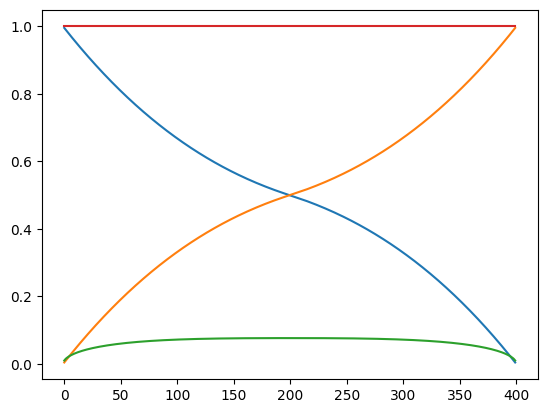

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

steps = np.linspace(0, 399, 400)
steps = steps.astype(int).tolist()
steps = torch.tensor(steps).long()

plt.plot(steps, model.mu_x0[steps].cpu())
plt.plot(steps, model.mu_x1[steps].cpu())
plt.plot(steps, model.std_sb[steps].cpu())
plt.plot(steps, model.mu_x1[steps].cpu() + model.mu_x0[steps].cpu())

In [5]:
train_iter = save_iter(train_loader, train_sampler)

In [6]:
batch = next(train_iter)

In [7]:
batch = to_cuda(batch, "cuda")
data_batch = get_data_batch(batch=batch, cfg=cfg)

x0 = data_batch["hr_points"]
x1 = data_batch["lr_points"] if data_batch["lr_points"] is not None else None
features = data_batch["features"] if data_batch["features"] is not None else None

In [8]:
x0 = x0[:, :, :8]
x1 = x1[:, :, :8]

In [9]:
x0.shape, x1.shape

(torch.Size([4, 3, 8]), torch.Size([4, 3, 8]))

In [10]:
import torch

outs = []
outs_fixed = []

for t in range(0, cfg.diffusion.timesteps, 10):
    # make t batch size
    t = torch.tensor(t).reshape(1,).long()
    t = t.repeat(x0.shape[0])
    out = model.q_sample(x1=x1, x0=x0, step=t).squeeze()
    outs.append(out.cpu().numpy())

In [11]:
import numpy as np

outs = np.array(outs)

In [12]:
o = outs[:, 0, :, :]
x0 = x0[:1, :, :]
x1 = x1[:1, :, :]

In [13]:
o.shape

(40, 3, 8)

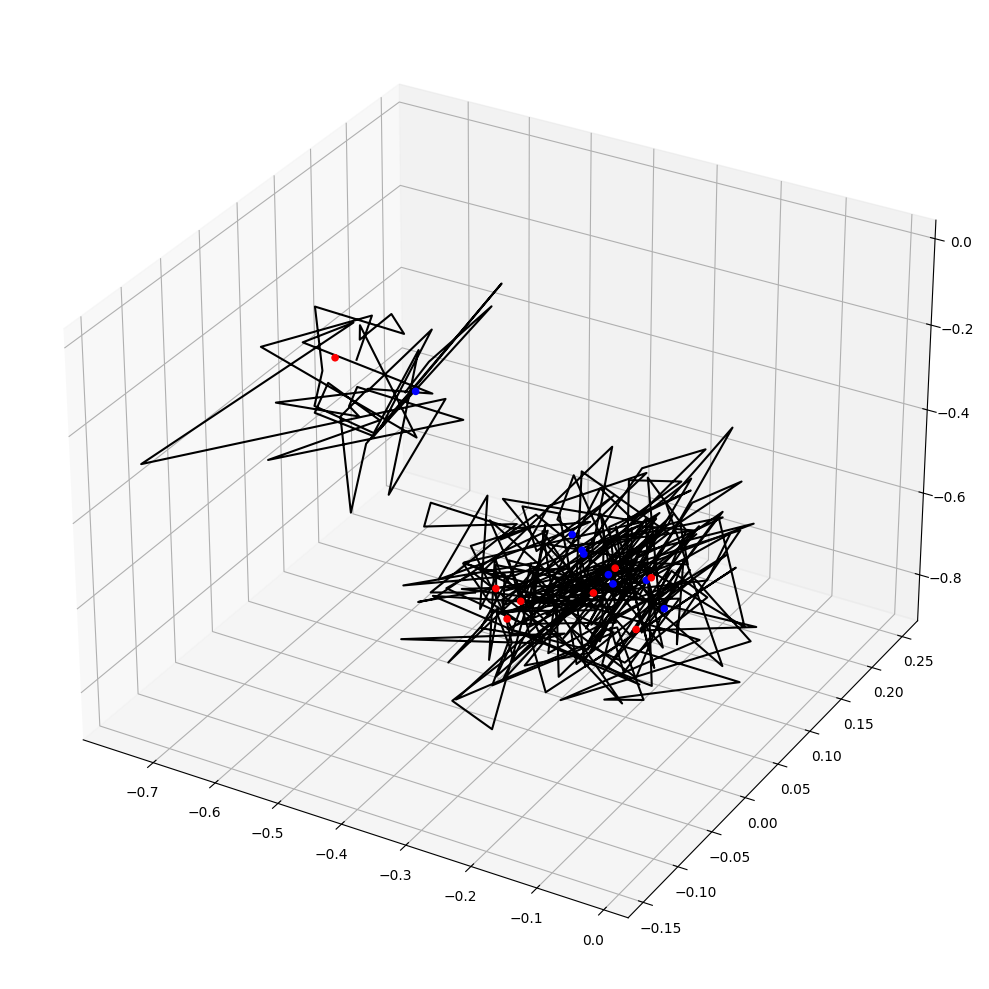

In [14]:
import matplotlib.pyplot as plt

# plot x0 and x1 and the outs as trajectory in betwen them, plot 3d
# outs have shape (3 x N)

ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.scatter(x0[0, 0, :].cpu().numpy(), x0[0, 1, :].cpu().numpy(), zs=x0[0, 2, :].cpu().numpy(), color="blue", alpha=1)
ax.scatter(x1[0, 0, :].cpu().numpy(), x1[0, 1, :].cpu().numpy(), zs=x1[0, 2, :].cpu().numpy(), color="red", alpha=1)

# for each point in outs, plot the trajectory in 3d, outs has shape (T, 3, P)
# where P are the points
for i in range(o.shape[2]):
    ax.plot(o[:, 0, i], o[:, 1, i], zs=o[:, 2, i], color="black", alpha=1)

plt.tight_layout()
plt.show()

In [ ]:
import torch

test = torch.ones(4, 3, 4).cuda()
steps = [1, 100, 500, 800]
test_out = model.q_sample(x1=test, x0=torch.zeros_like(test), step=steps, ot_ode=True)
test_out